
<a name="Overview"></a>
## Overview

In this notebook, we will be performing Exploratory Data Analysis on a dataset of Titanic passengers.

We aim to answer the following questions using this data:

* What is the most important factor in determining survival of the Titanic incident?
* In the movie, the upper-class passengers were given preference on lifeboats. Does this show in the data?
* “Womenandchildrenfirst”. Was this the case?
* Note another observation we can make from the data

<a name="Table-of-contents"></a>
## Table of Contents

* [Overview](#Overview)
* [Table of Contents](#Table-of-contents)
* [Libraries Used](#Libraries-Used)
* [Data Structure](#Data-Structure)
* [Missing Data](#Missing-data)
* [Pre-Processing](#Pre-processing)
* [Categorization](#Categorization)
* [Observations](#Observations)

## Libraries-Used

This notebook was written using python 3.12.2

Please also see requirements.txt for exact versions of key libraries.

In [1414]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

[^ Back to table of contents ^](#Table-of-contents)

<a name="Data-Structure"></a>
## Data structure

Let's load the data and take a look at what we have

### Features

In [1415]:
df = pd.read_csv('Titanic.csv')

print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1416]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Some of those features are self explanatory, but a few I had no idea what they referred to and no meta-data was provided.

Luckily, this is a very commonly used dataset, so I was able to find this description of the features online:

| Feature      | Description                                |
|--------------|--------------------------------------------|
| Pclass       | Ticket class                               |
| SibSp        | # of siblings / spouses aboard the Titanic |
| Parch        | # of parents / children aboard the Titanic |
| ticket       | Ticket number                              |

[^ Back to table of contents ^](#Table-of-contents)

<a name="Missing-data"></a>
## Missing Data

In [1417]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Missing Data: Cabin
Out of 891 records, we're missing 687 entries for Cabin.


In [1418]:
# Let's take a peek at the first 10 unique values
df["Cabin"].unique()[:10]

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78'], dtype=object)

This data is potentially useful (Did cabin number indicate which deck it was on, and were some decks more dangerous than others?).  We could produce a feature "Deck" from this data which might be interesting.

Unfortunately the very high level of missing data is likely to do with poor record-keeping, and either we won't be able to sensibly predict deck for the observations without this data, or it would effectively map to another feature *pclass* making it redundant.

So I'm going to just drop this feature for now.

In [1419]:
df.drop(columns=["Cabin"], inplace=True)

The proportion of survived values is about the same, so it should be safe to assign the mode to missing values without introducing too much bias

### Missing Data: Age

There's a large amount of age data missing, I believe this is MCAR and is just a case of bad records. So we should be able to enter the mean age value here without introducing too much bias

#### 2nd iteration - distributions of age data based on class
After the first iteration of analysis, I observed that age distribution was different between class.  We can use this to set more appropriate ages per class



<Axes: xlabel='Age', ylabel='Density'>

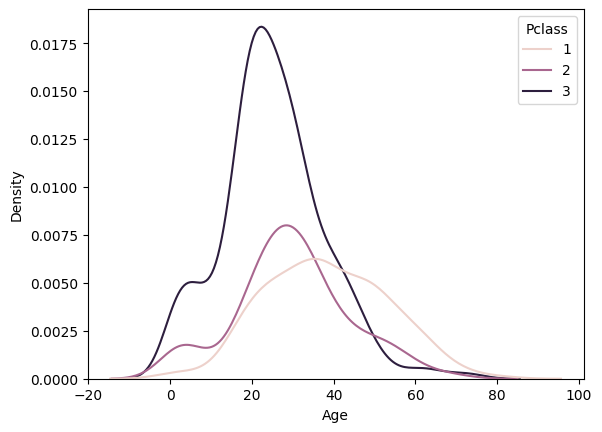

In [1420]:
df_withage = df.loc[df['Age'].isnull() == False, ['Age', 'Pclass', 'Survived']]
sns.kdeplot(df_withage, x="Age", hue="Pclass")

In [1421]:
# Setting age to mean of age for class
grouped = df_withage.groupby(['Pclass'])
grouped.describe()

Age                                                     Survived  \
        count       mean        std   min   25%   50%   75%   max    count   
Pclass                                                                       
1       186.0  38.233441  14.802856  0.92  27.0  37.0  49.0  80.0    186.0   
2       173.0  29.877630  14.001077  0.67  23.0  29.0  36.0  70.0    173.0   
3       355.0  25.140620  12.495398  0.42  18.0  24.0  32.0  74.0    355.0   

                                                     
            mean       std  min  25%  50%  75%  max  
Pclass                                               
1       0.655914  0.476352  0.0  0.0  1.0  1.0  1.0  
2       0.479769  0.501041  0.0  0.0  0.0  1.0  1.0  
3       0.239437  0.427342  0.0  0.0  0.0  0.0  1.0

The median and mean values for age aren't too far apart, indicating our distributions when categorised by Pclass aren't heavily skewed and are relatively normally distributed.

We can now set the missing age data to these means without introducing too much bias.

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64


<Axes: xlabel='Age', ylabel='Density'>

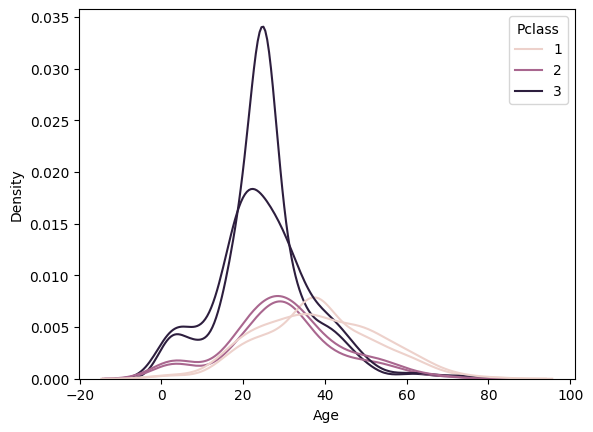

In [1422]:
print(df.isnull().sum())

mean_ages = []
for key, group in grouped:
    mean = round(group['Age'].mean())
    mean_ages.append(mean)
    df.loc[(df['Pclass'] == key[0]) & (df['Age'].isnull()), ['Age']] = round(group['Age'].mean())

# Make subplot?

sns.kdeplot(df, x="Age", hue="Pclass")
sns.kdeplot(df_withage, x="Age", hue="Pclass")

We can see that doing this has increased the peaks (especially for 3rd class passengers), but has not massively impacted the overall shape of the data.

Has this skewed the survival data for the mean age values?



In [1423]:
for age in mean_ages:    
    mean_survived_before = df_withage[df_withage['Age'] == age]['Survived'].mean()
    mean_surived_after =  df[df['Age'] == age]['Survived'].mean()
    print(f"For {age}, survived {round(mean_survived_before, 2)} -> {round(mean_surived_after, 2)}")

For 38, survived 0.45 -> 0.46
For 30, survived 0.4 -> 0.39
For 25, survived 0.26 -> 0.25


There has only been a very minor change in survivability for the ages used for missing data, so all looks good!

### Missing data: Embarked

Only 2 observations with this feature missing, I believe this is MCAR so let's just set it to the most frequest value (S)

In [1424]:
df['Embarked'].value_counts()

df.loc[df['Embarked'].isnull(), 'Embarked'] = 'S'


### Missing data status after imputing

In [1425]:

df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

No more missing values!

[^ Back to table of contents ^](#Table-of-contents)

<a name="#pre-processing"></a>

## Pre-processing



### Any Outliers to remove?

There only non-discrete numeric values in this dataset is fare, let's run a box plot of this to see if there are a lot of outliers.

If there are, let's windsorize this data

Text(0.5, 1.0, 'Looking for Outliers')

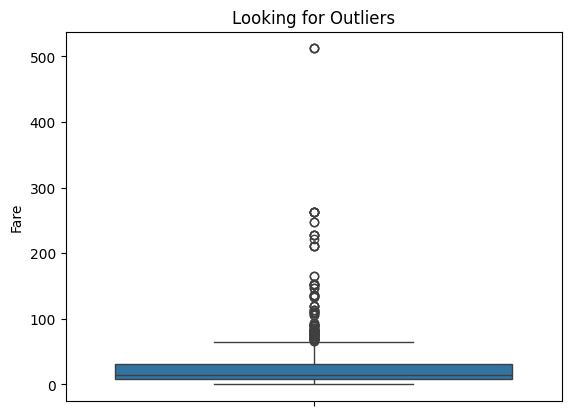

In [1427]:
sns.boxplot(df['Fare']).set_title("Looking for Outliers")

Text(0.5, 1.0, 'After Windsorization')

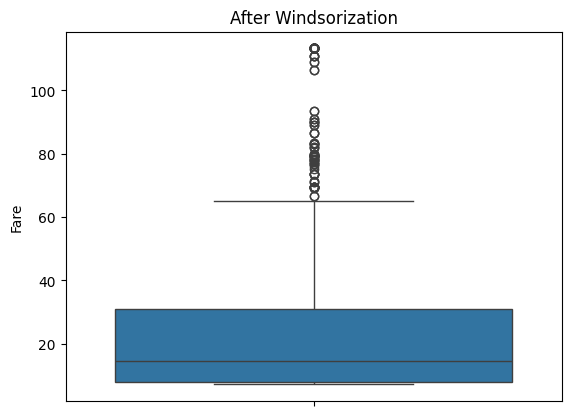

In [1428]:

len(df['Fare'].unique())

from scipy.stats import mstats

df['Fare'] = mstats.winsorize(df['Fare'], limits=[0.05, 0.05])


# df.hist(figsize=[10, 10])
sns.boxplot(df['Fare']).set_title("After Windsorization")

According to this data, Fare's for the titanic were very varied!

[^ Back to table of contents ^](#Table-of-contents)

<a name="#Categorization"></a>
## Categorization

Most of our data is categorical already.  Of the two that aren't (Age and Fare), they could both benefit from being categorized.

### Age

For age, let's add a feature "Child" which we can use to help answer the question about whether "Women and Children first" was true!

12 was age of leaving school in 1912 according to https://en.wikipedia.org/wiki/Raising_of_school_leaving_age_in_England_and_Wales



<Axes: xlabel='Survived', ylabel='Count'>

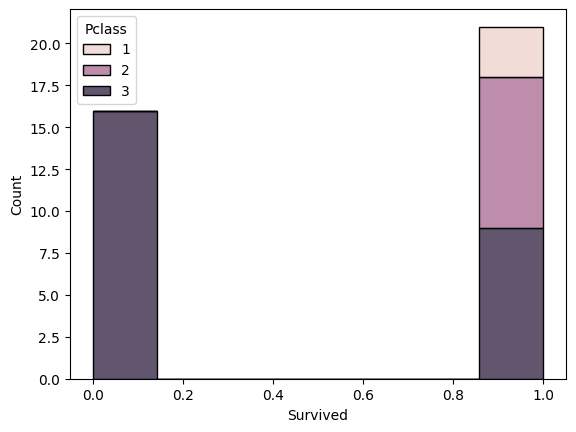

In [1429]:
df['Child'] = False
df.loc[df['Age'] <= 12, 'Child'] = True 
sns.histplot(df[(df['Child'] == True) & (df['Sex'] == "male")], x="Survived", hue="Pclass", color="tab10", multiple="stack")



### Fare

We could categorize Fare into ranges.

However as I'm not convinced Fare is going to be a factor in the target features we're interested in (survivability), I'm not going to do this for now.

[^ Back to table of contents ^](#Table-of-contents)

<a name="#Observations"></a>
## Observations

### What features strongly relate to survived?

<Axes: xlabel='Parch', ylabel='Survived'>

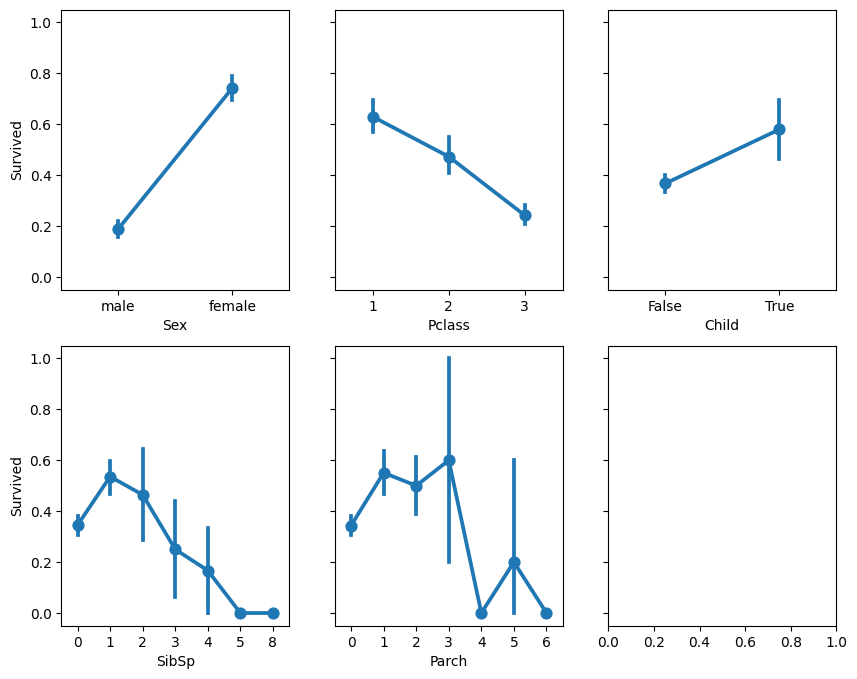

In [1430]:
(f, ax) = plt.subplots(2,3, figsize=(10,8), sharey=True)
# plt.tight_layout()
sns.pointplot(df, x='Sex', y="Survived", ax=ax[0][0])
sns.pointplot(df, x='Pclass', y="Survived", ax=ax[0][1])
sns.pointplot(df, x='Child', y="Survived", ax=ax[0][2])
sns.pointplot(df, x='SibSp', y="Survived", ax=ax[1][0])
sns.pointplot(df, x='Parch', y="Survived", ax=ax[1][1])

### Sex is the most important factor

We can see from this the largest relation for survivability is Sex.  Females had a much higher number of Survived than Male.


### Class helped
This is then followed by class (1st class having best survivability, 3rd having worst), indicating first class passengers did get preference (to a certain extent)

Then being a Child helped (in this case we classed a child as <= 12 Years old, though varying this threshold between 12<->18 did not significantly change this).

SibSp and Parch did not have high confidence when determining survivability (the vertical lines in the graph), and due to the mixed information in these data values (siblings and spouses classed as the same?), I don't think these features are useful.

### Was it women and children first?

We know that both being female, and a child were strong indicators towards surviving, but did class outweight this at times?

Text(0.5, 1.0, 'Other')

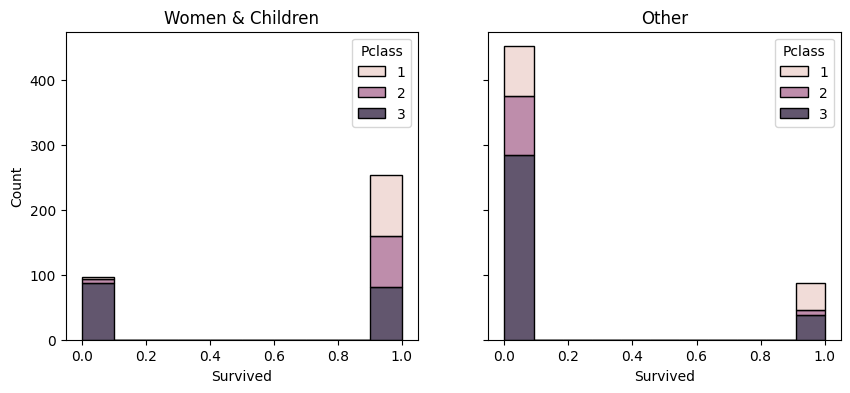

In [1431]:
(f, ax) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.histplot(df[(df['Sex'] == 'female') | (df['Child'] == True)], x="Survived", hue="Pclass", multiple="stack", ax=ax[0]).set_title("Women & Children")
sns.histplot(df[(df['Sex'] != 'female') & (df['Child'] == False)], x="Survived", hue="Pclass", multiple="stack", ax=ax[1]).set_title("Other")

It was predominately Women & Children first, though not exclusively.

We can see from the data a lot of 3rd class women & children did not survive behind.  Whether this was because they were unable to get to the lifeboats, others took their places, or they did not survive after getting in the lifeboat, we can not tell from the data.

### Other Observations

#### Age distributions in different classes

<Axes: xlabel='Age', ylabel='Density'>

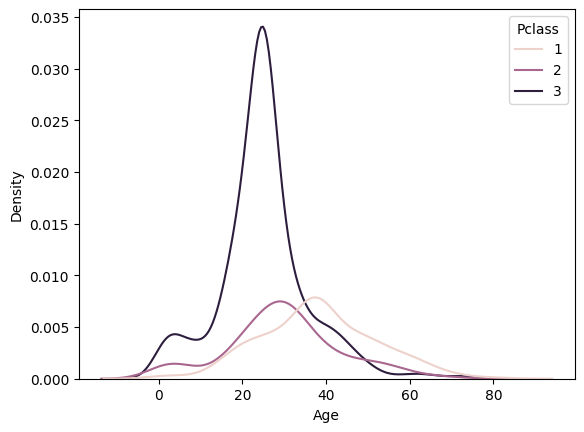

In [1432]:
sns.kdeplot(data=df, x="Age", hue="Pclass")

There's an interesting difference in density of passengers ages between classes.

For example 1st class passengers are a wider spread of ages, with higher mean age.

3rd class passengers are predominently a certain age around the 20s.

#### Fares in relation to Embarked

<Axes: xlabel='Fare'>

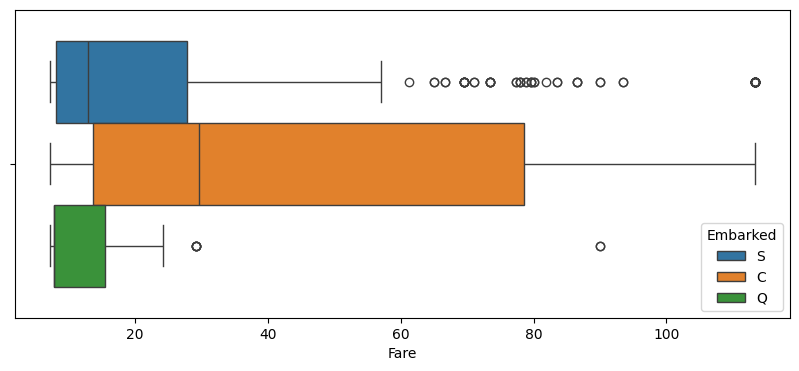

In [1433]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df, x="Fare", hue="Embarked")

We can see from this that fares in general were:

* cheapest when boarding from location "Q"
* Most expensive on average from "C"
* Had the widest variation from "C"

though there were quite a few outliers for all locations.

We could consider another iteration of exploration on this, possibly applying windsoration of Fare based on Embarked values, instead of over the entire dataset.  We could also perhaps more accurately impute the missing Embarked values using this Fare data.


[^ Back to table of contents ^](#Table-of-contents)